In [ ]:
#| echo: false
import logging
import warnings

In [ ]:
#| echo: false
warnings.simplefilter('ignore')
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# Probabilistic Forecasting 

> In this example, we'll implement prediction intervals 

::: {.callout-warning collapse="true"}

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short) 

:::

## Introduction 

When we generate a forecast, we usually produce a single value known as the point forecast. This value, however, doesn't tell us anything about the uncertainty associated with the forecast. To have a measure of this uncertainty, we need **prediction intervals**. 

A prediction interval is a range of values that the forecast can take with a given probability. Hence, a 95% prediction interval should contain a range of values that include the actual future value with probability 95%. Probabilistic forecasting aims to generate the full forecast distribution. Point forecasting, on the other hand, usually returns the mean or the median or said distribution. However, in real-world scenarios, it is better to forecast not only the most probable future outcome, but many alternative outcomes as well. 

[StatsForecast](../../index) has many models that can generate point forecasts. It also has probabilistic models than generate the same point forecasts and their prediction intervals. These models are stochastic data generating processes that can produce entire forecast distributions. By the end of this tutorial, you'll have a good understanding of the probabilistic models available in StatsForecast and will be able to use them to generate point forecasts and prediction intervals. Furthermore, you'll also learn how to generate plots with the historical data, the point forecasts, and the prediction intervals. 

::: {.callout-important}
## Important 
Although the terms are often confused, prediction intervals are not the same as [confidence intervals](https://robjhyndman.com/hyndsight/intervals/). 

:::

::: {.callout-warning}
## Warning 
In practice, most prediction intervals are too narrow since models do not account for all sources of uncertainty. A discussion about this can be found [here](https://robjhyndman.com/hyndsight/narrow-pi/).

:::


**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models 
4. Plot prediction intervals 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

Install the necessary packages using `pip install statsforecast`

In [ ]:
%pip install -U statsforecast

## Load and explore the data

For this example, we'll use the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). We first need to download the data from a URL and then load it as a `pandas` dataframe. Notice that we'll load the train and the test data separately. We'll also rename the `y` column of the test data as `y_test`.   

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [ ]:
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [ ]:
test.head()

,unique_id,ds,y_test
0,H1,701,619.0
1,H1,702,565.0
2,H1,703,532.0
3,H1,704,495.0
4,H1,705,481.0


Since the goal of this notebook is to generate prediction intervals, we'll only use the first 8 series of the dataset to reduce the total computational time. 

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the `statsforecast.plot` method from the [StatsForecast](../../core#class-statsforecast) class. This method has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`]. 
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models. 
- `plot_random`: bool = `True`. Plots the time series randomly. 
- `models`: List[str]. A list with the models we want to plot. 
- `level`: List[float]. A list with the prediction intervals we want to plot. 
- `engine`: str = `plotly`. It can also be `matplotlib`. `plotly` generates interactive plots, while `matplotlib` generates static plots. 

In [ ]:
from statsforecast import StatsForecast

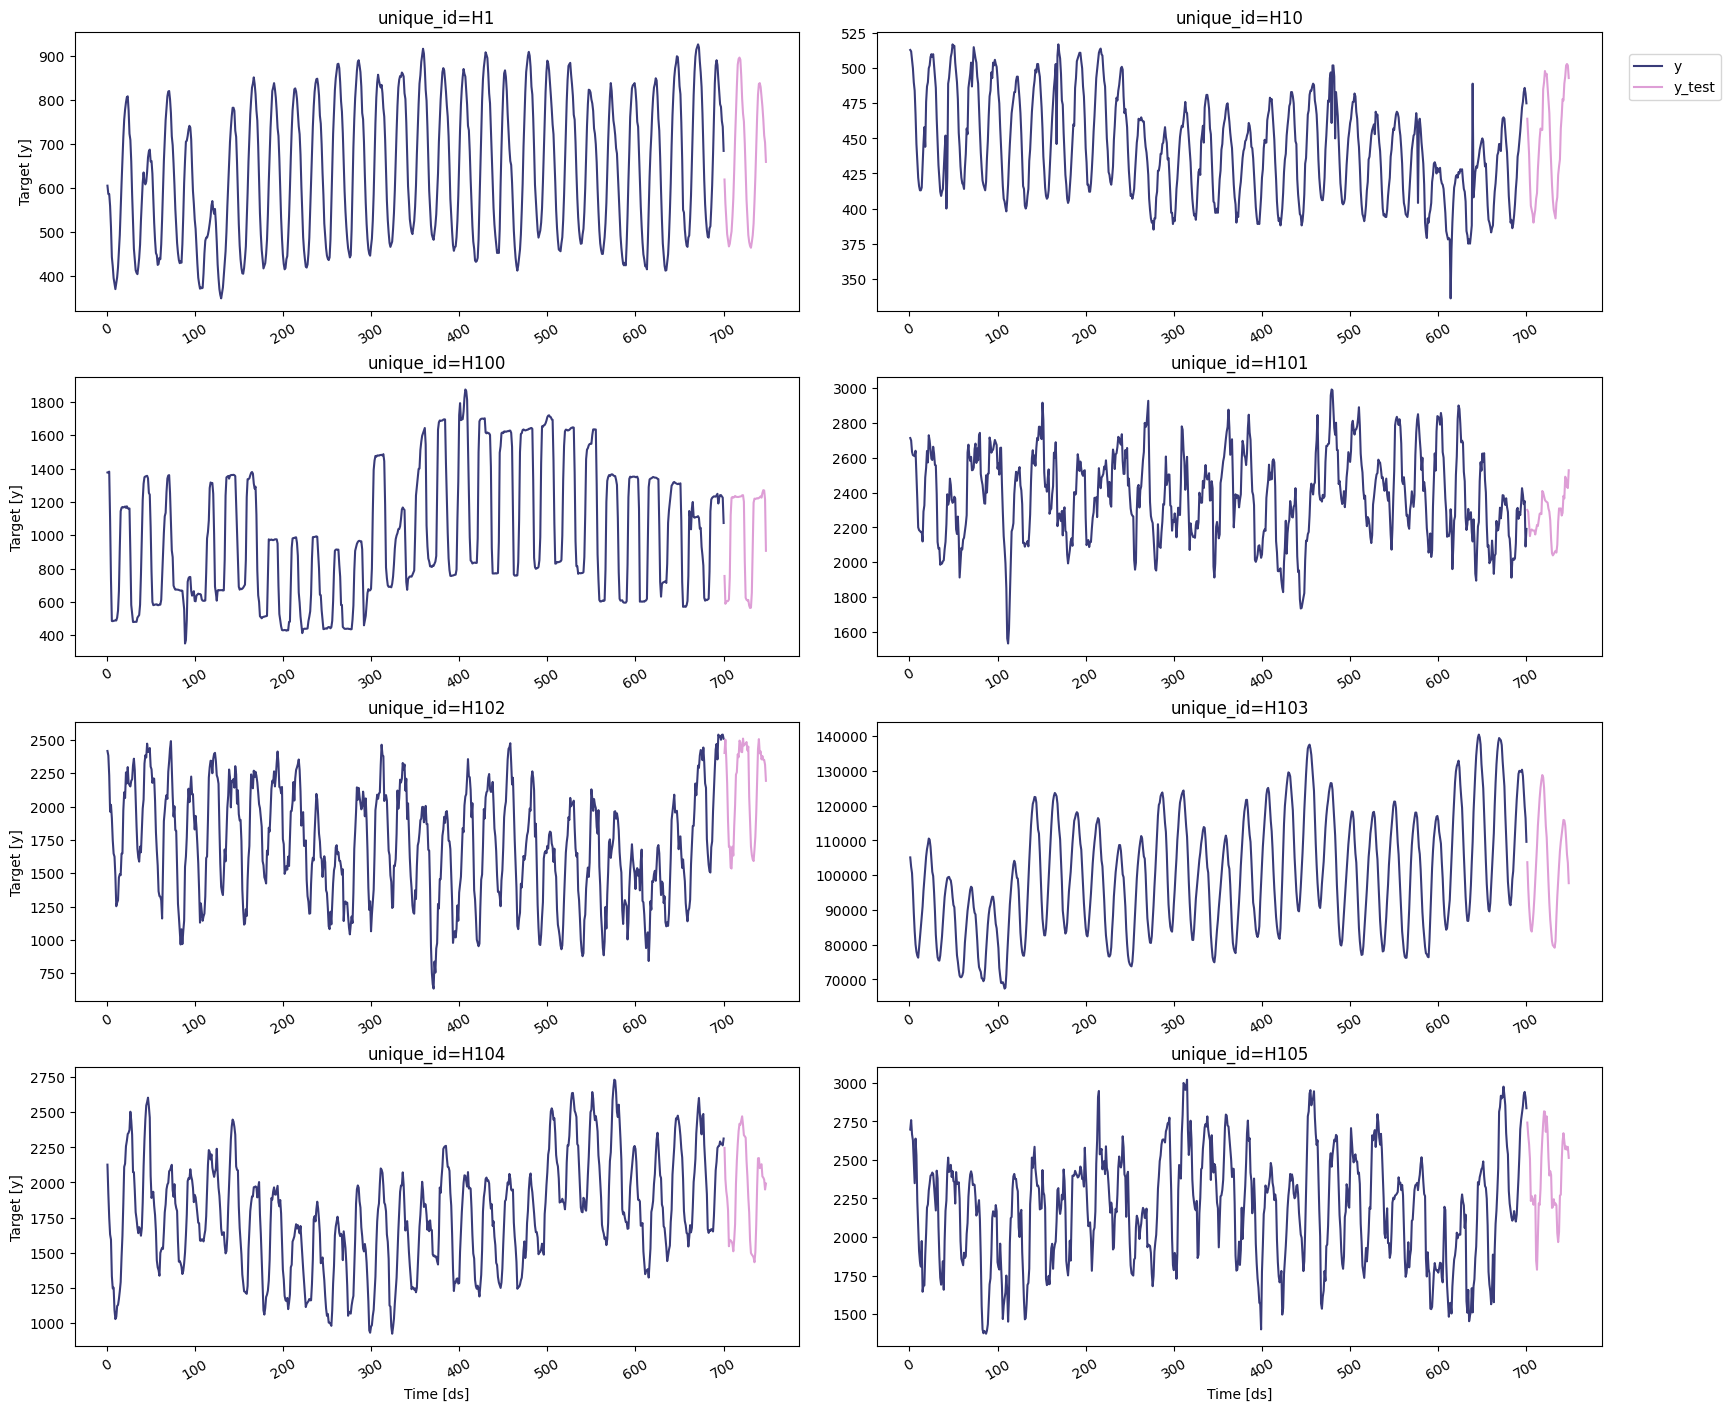

In [ ]:
StatsForecast.plot(train, test, plot_random=False)

## Train models

StatsForecast can train multiple [models](../../models) on different time series efficiently. Most of these models can generate a probabilistic forecast, which means that they can produce both point forecasts and prediction intervals.

For this example, we'll use [AutoETS](../models/AutoETS) and the following baseline models: 

- [HistoricAverage](../../models#class-historicaverage)
- [Naive](../../models#class-naive)
- [RandomWalkWithDrift](../../models#class-randomwalkwithdrift) 
- [SeasonalNaive](../../models#class-seasonalnaive)

To use these models, we first need to import them from `statsforecast.models` and then we need to instantiate them. Given that we're working with hourly data, we need to set `seasonal_length=24` in the models that requiere this parameter. 

In [ ]:
from statsforecast.models import (
    AutoETS,
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive
)

In [ ]:
# Create a list of models and instantiation parameters
models = [
    AutoETS(season_length=24),
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=24)
]

To instantiate a new StatsForecast object, we need the following parameters: 

- `df`: The dataframe with the training data. 
- `models`: The list of models defined in the previous step.  
- `freq`: A string indicating the frequency of the data. See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores. 

In [ ]:
sf = StatsForecast(
    models=models,
    freq=1,
    n_jobs=-1
)

Now we're ready to generate the point forecasts and the prediction intervals. To do this, we'll use the `forecast` method, which takes two arguments: 

- `h`: An integer that represent the forecasting horizon. In this case, we'll forecast the next 48 hours. 
- `level`: A list of floats with the confidence levels of the prediction intervals. For example, `level=[95]` means that the range of values should include the actual future value with probability 95%. 

In [ ]:
levels = [80, 90, 95, 99] # confidence levels of the prediction intervals

forecasts = sf.forecast(df=train, h=48, level=levels)
forecasts.head()

,unique_id,ds,AutoETS,AutoETS-lo-99,AutoETS-lo-95,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90,AutoETS-hi-95,...,RWD-hi-99,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-lo-90,SeasonalNaive-lo-95,SeasonalNaive-lo-99,SeasonalNaive-hi-80,SeasonalNaive-hi-90,SeasonalNaive-hi-95,SeasonalNaive-hi-99
0,H1,701,631.889598,533.371822,556.926831,568.978861,582.874079,680.905116,694.800335,706.852365,...,789.416619,691.0,613.351903,591.339747,572.247484,534.932739,768.648097,790.660253,809.752516,847.067261
1,H1,702,559.750830,460.738592,484.411824,496.524343,510.489302,609.012359,622.977317,635.089836,...,833.254152,618.0,540.351903,518.339747,499.247484,461.932739,695.648097,717.660253,736.752516,774.067261
2,H1,703,519.235476,419.731233,443.522100,455.694808,469.729161,568.741792,582.776145,594.948853,...,866.990616,563.0,485.351903,463.339747,444.247484,406.932739,640.648097,662.660253,681.752516,719.067261
3,H1,704,486.973364,386.979536,410.887460,423.120060,437.223465,536.723263,550.826668,563.059268,...,895.510095,529.0,451.351903,429.339747,410.247484,372.932739,606.648097,628.660253,647.752516,685.067261
4,H1,705,464.697366,364.216339,388.240749,400.532950,414.705071,514.689661,528.861782,541.153983,...,920.702904,504.0,426.351903,404.339747,385.247484,347.932739,581.648097,603.660253,622.752516,660.067261


We'll now merge the forecasts and their prediction intervals with the test set. This will allow us generate the plots of each probabilistic model. 

In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot prediction intervals

To plot the point and the prediction intervals, we'll use the `statsforecast.plot` method again. Notice that now we also need to specify the model and the levels that we want to plot. 

### AutoETS

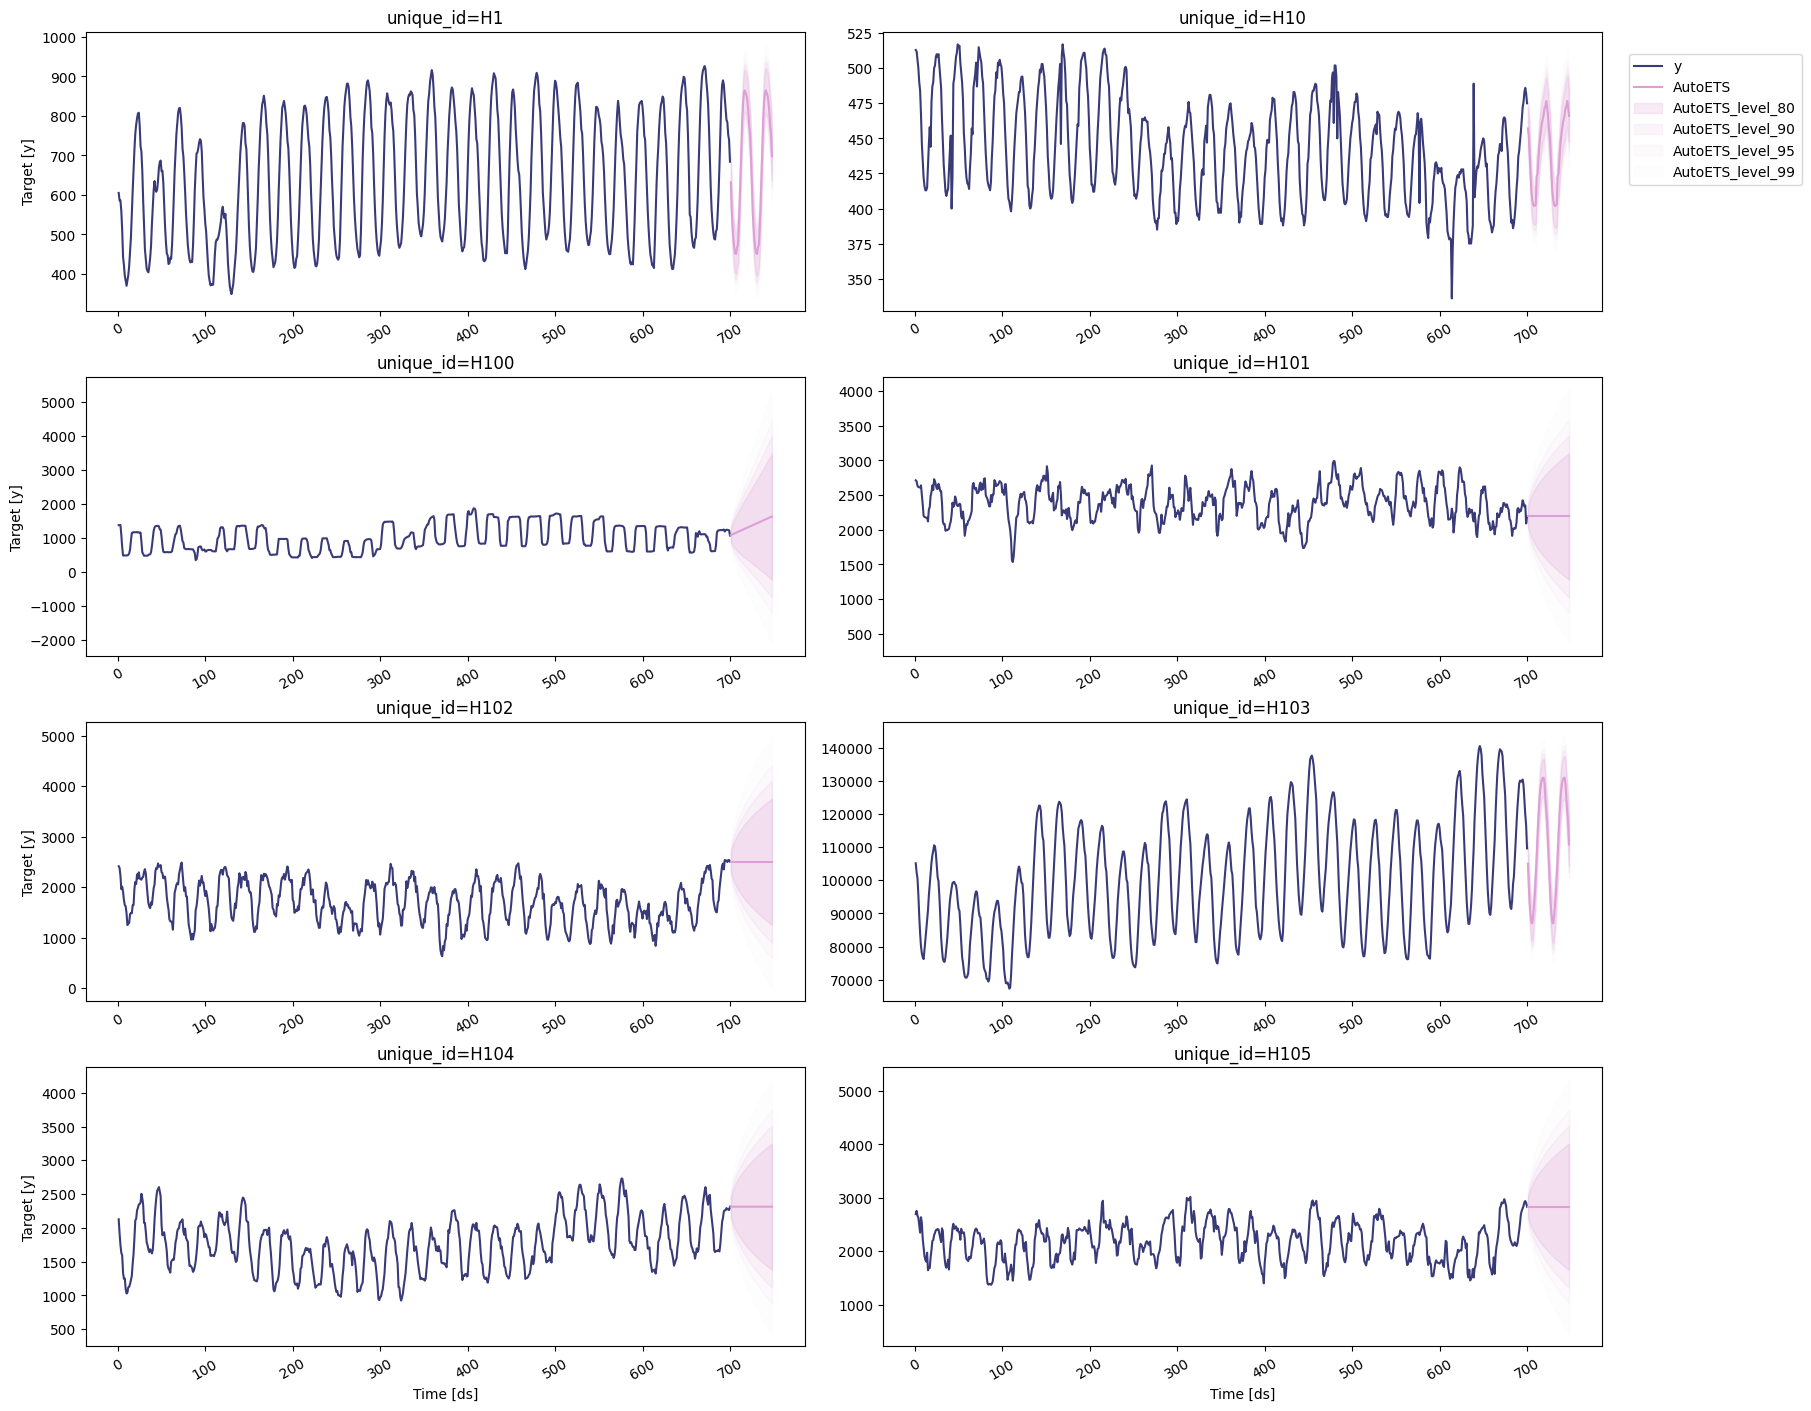

In [ ]:
sf.plot(train, test, plot_random=False, models=['AutoETS'], level=levels)

### Historic Average 

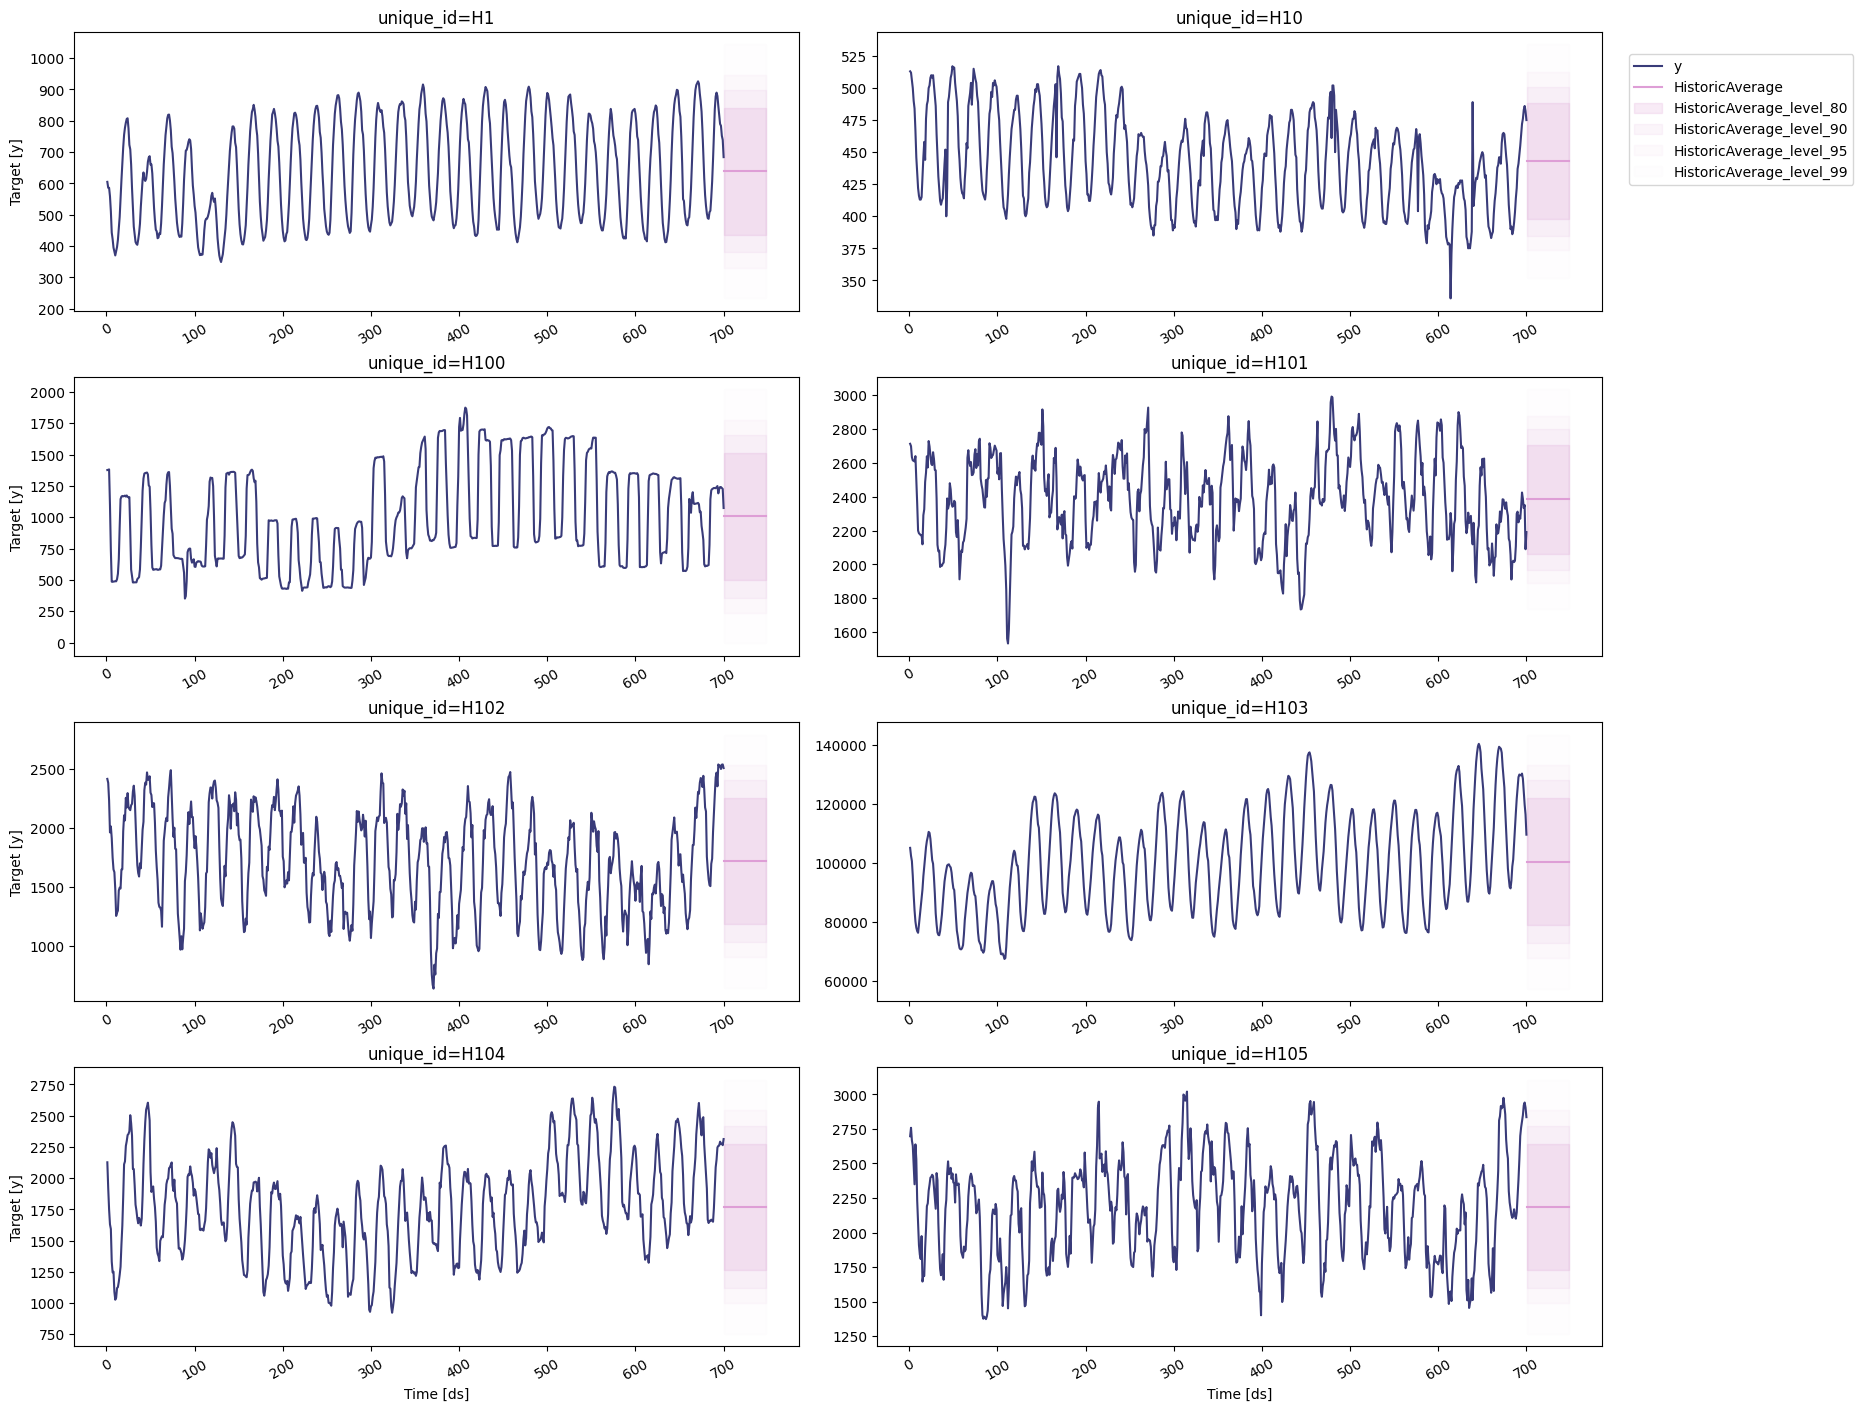

In [ ]:
sf.plot(train, test, plot_random=False, models=['HistoricAverage'], level=levels)

### Naive 

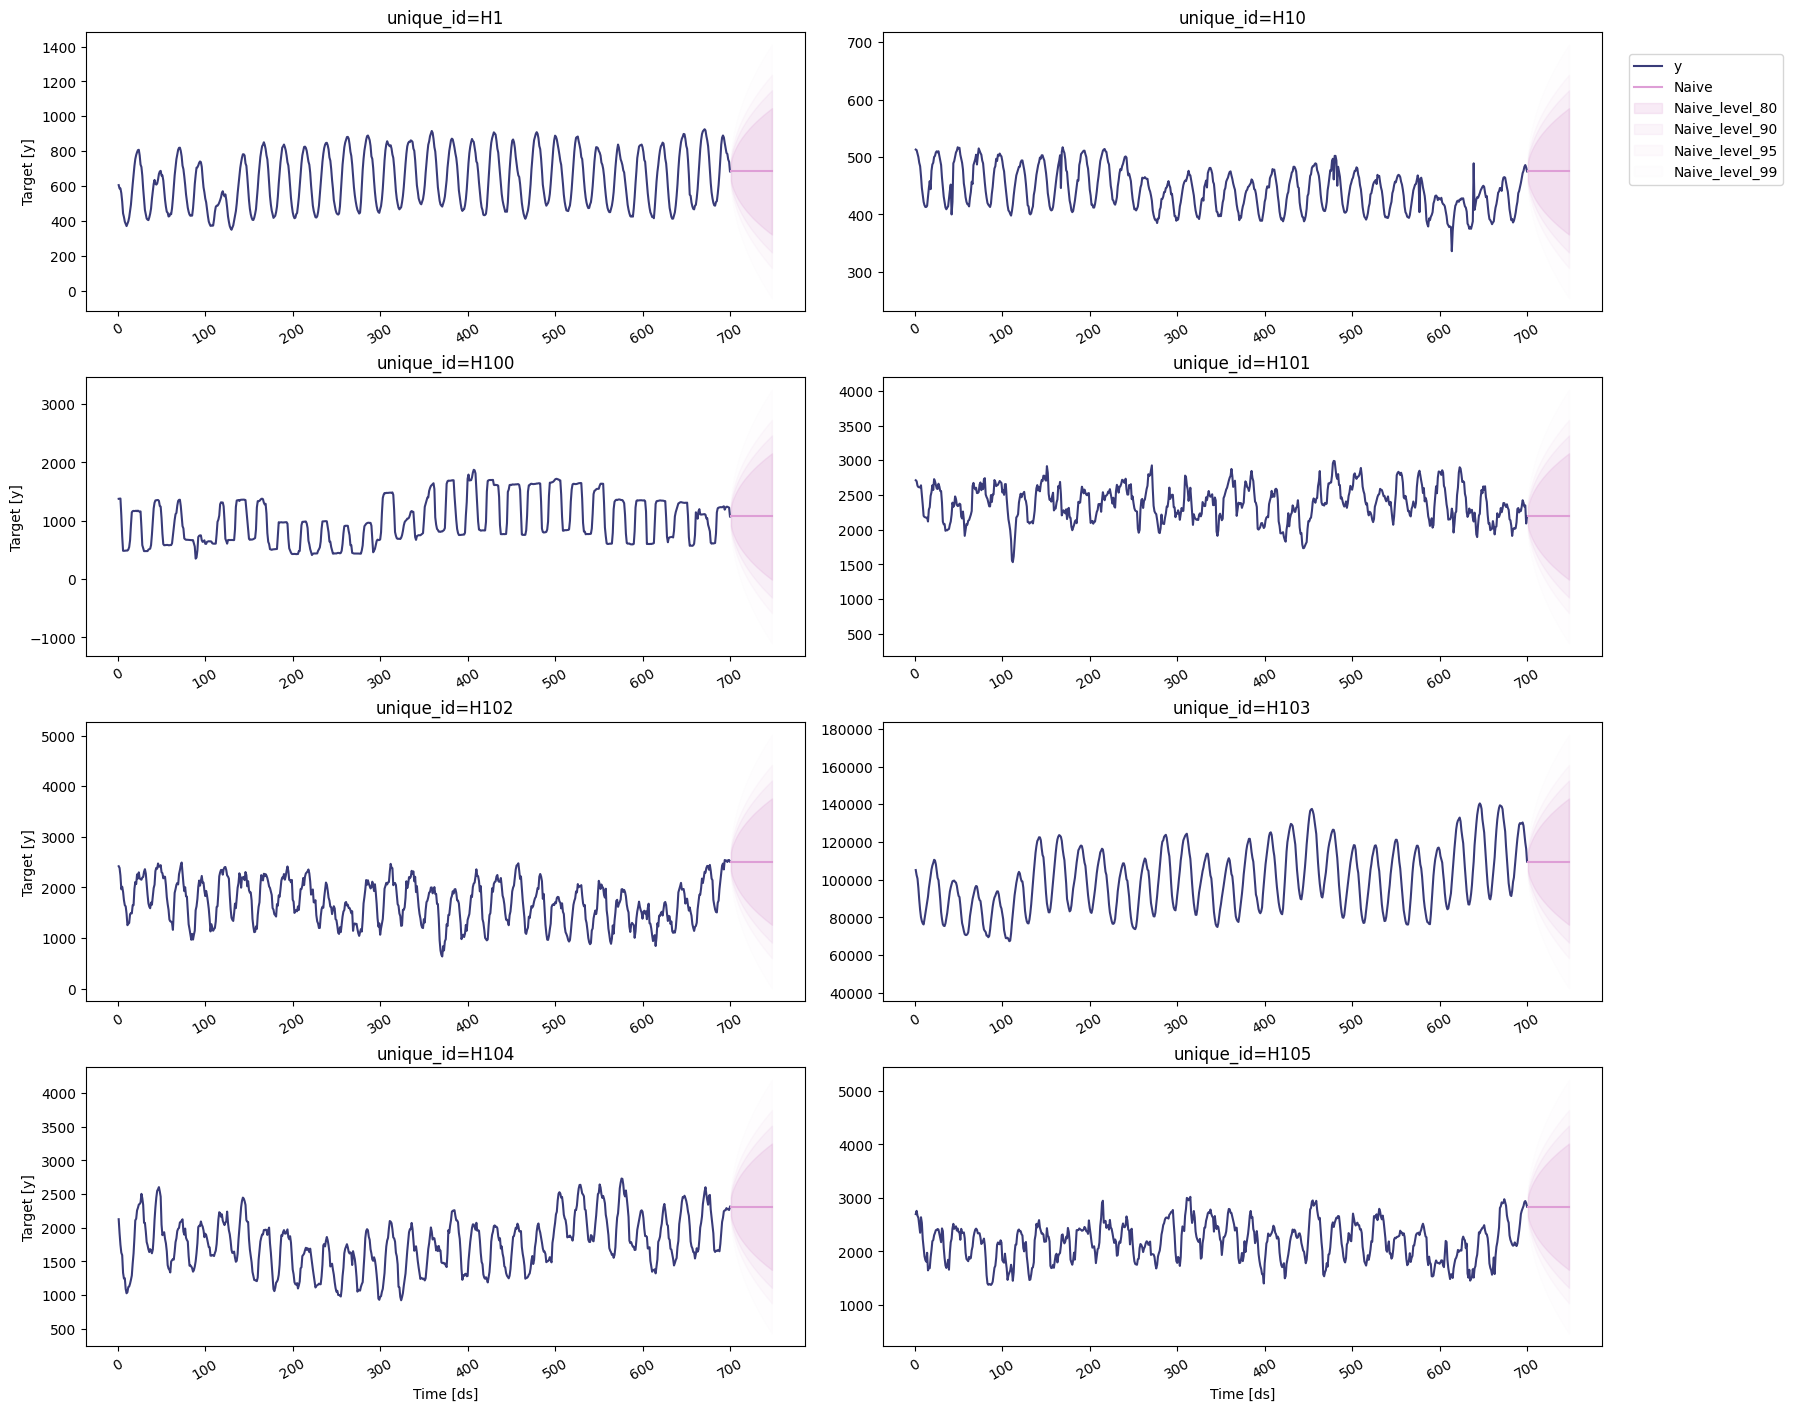

In [ ]:
sf.plot(train, test, plot_random=False, models=['Naive'], level=levels)

### Random Walk with Drift 

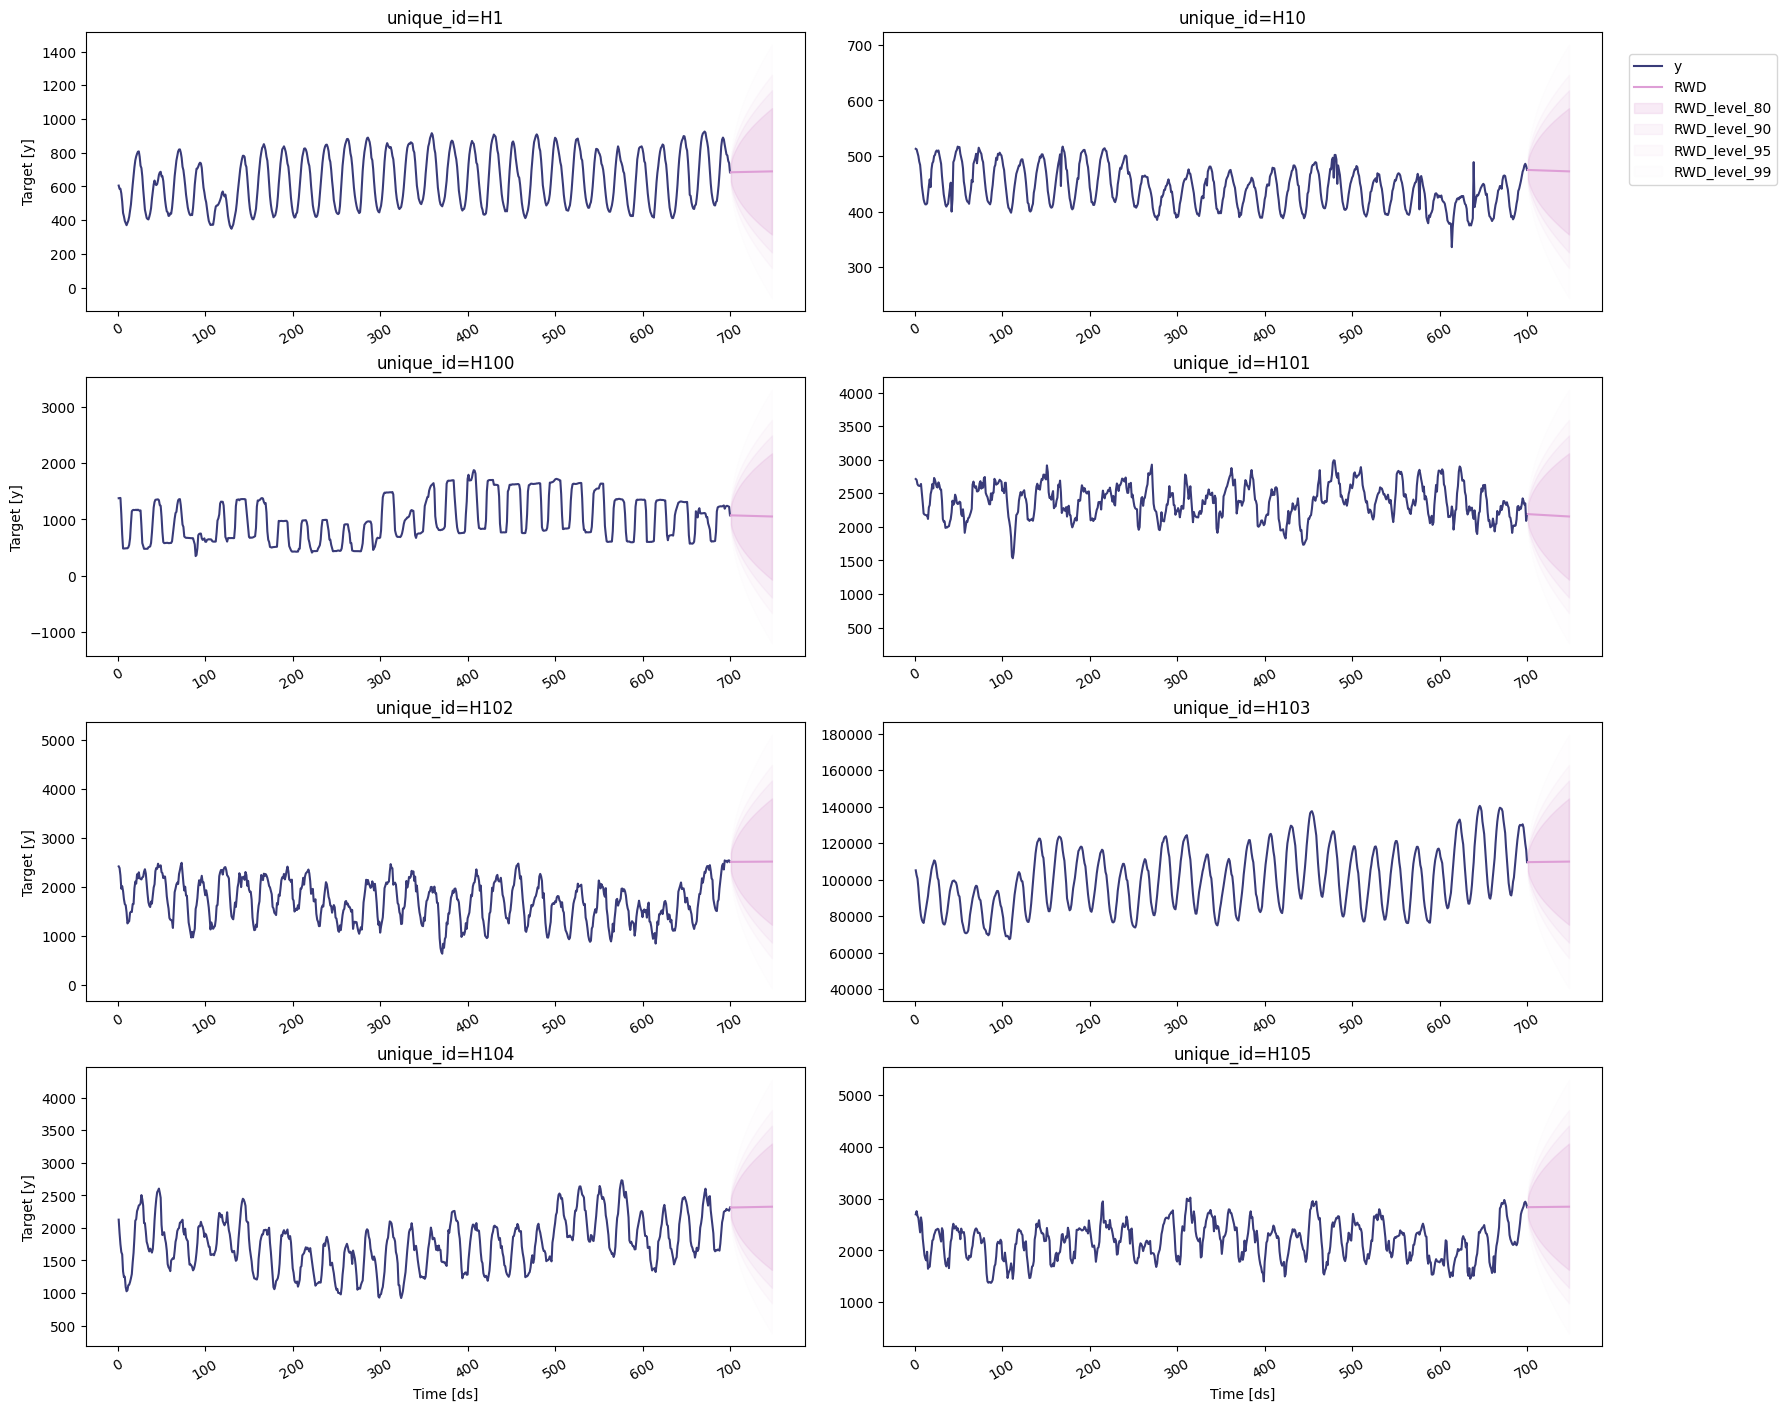

In [ ]:
sf.plot(train, test, plot_random=False, models=['RWD'], level=levels)

### Seasonal Naive 

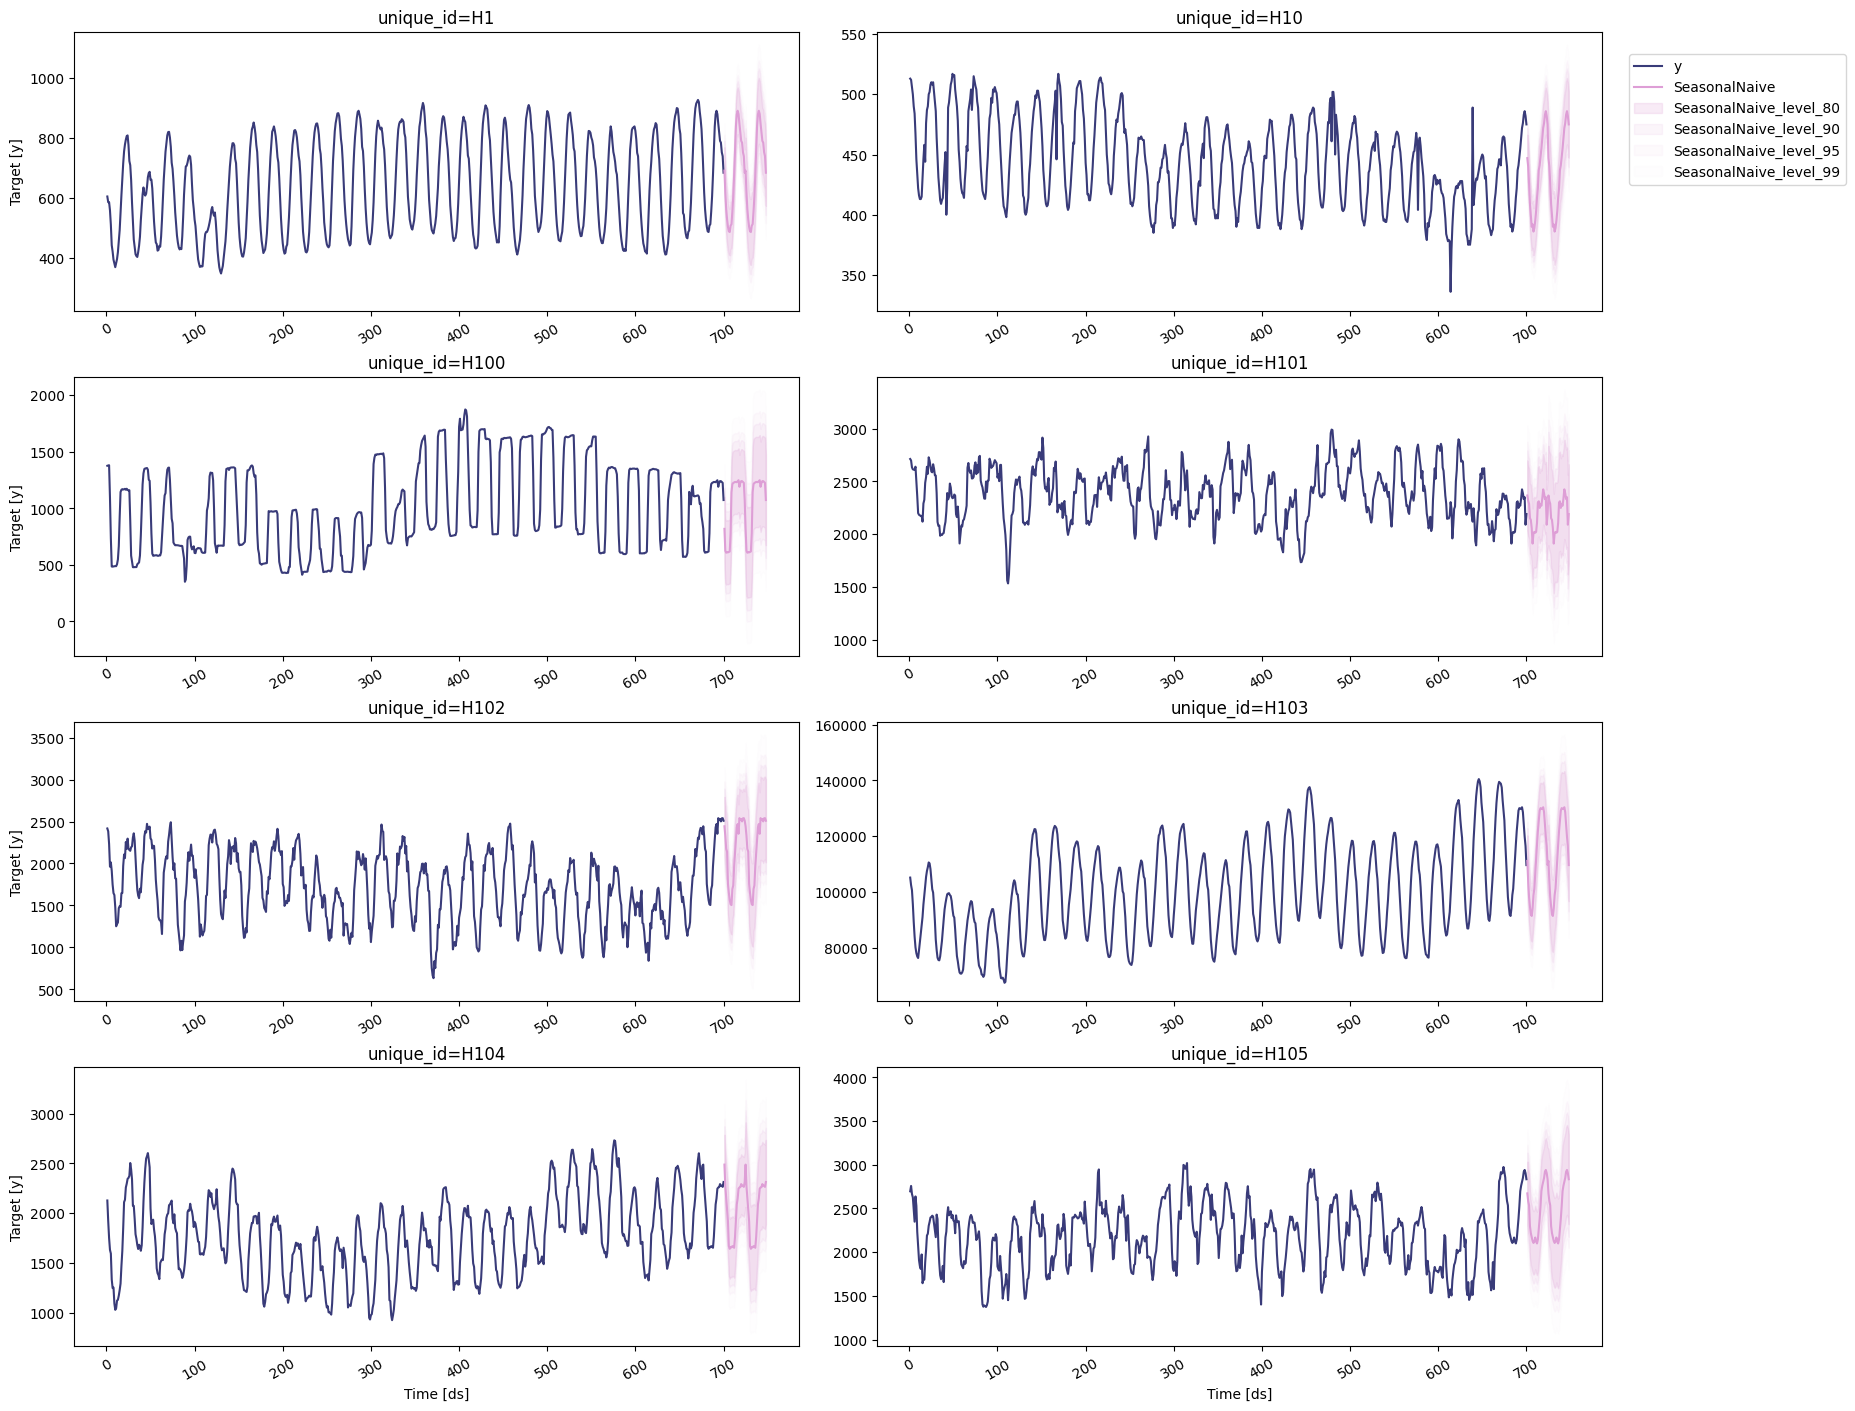

In [ ]:
sf.plot(train, test, plot_random=False, models=['SeasonalNaive'], level=levels)

From these plots, we can conclude that the uncertainty around each forecast varies according to the model that is being used. For the same time series, one model can predict a wider range of possible future values than others. 

## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, The Statistical Forecasting Perspective"](https://otexts.com/fpp3/perspective.html).